In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
rng = np.random.default_rng(7)

# Initial Poisson test

Initial test of downsampled scale CME with $f_{m}$ for poisson model using a discrete distribution of per cell capture efficiency.

## Simulate data

In [53]:
# model parameters
params = {
    'k_tx': 2,
    'k_deg': 1,
}

# simulate sample
sample = rng.poisson(params['k_tx'] / params['k_deg'], size=1000)

# capture dist
beta_dist = [1.0, 0.75, 0.5, 0.25]

# capture efficiencies
beta = rng.choice(beta_dist, size=1000)

# downsample
downsampled = rng.binomial(sample, beta)

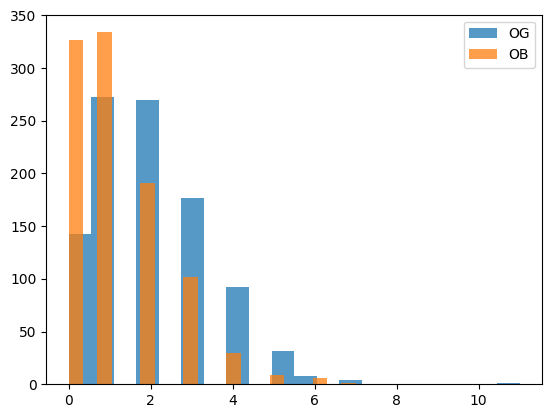

In [54]:
plt.hist(sample, alpha=0.75, label="OG", bins=20);
plt.hist(downsampled, alpha=0.75, label="OB", bins=20);
plt.legend()

In [55]:
def bootstrap_p(downsampled, N=1000, n=1000):
    '''
    N: number of bootstrap samples
    n: size of each bootstrap sample
    '''

    # number of m's observed
    M = int(np.max(downsampled)) + 1

    # setup estimates for p(m) for each m in each resample
    estimates = np.empty((N, M))

    # for each bootstrap sample
    for i in range(N):

        # resample
        boot = rng.choice(downsampled, size=n)

        # compute estimates over resample
        for m in range(M):
            estimates[i, m] = int((boot == m).sum()) / n

    # take quantiles across bootstrap samples
    intervals = np.quantile(estimates, [0.025, 0.975], axis=0)

    return intervals

## Bootstrapped p(m) agrees with truth (Poisson mixture over captures)

Standard bootstrap of observed distribution of counts produces confidence intervals that (95% of the time) agree with the true distribution, a mixture of poisson over the capture efficiency distribution

In [57]:
M = 8
p = np.zeros(M)
for b in beta_dist:
    p += scipy.stats.poisson.pmf([m for m in range(M)], b * params['k_tx'] / params['k_deg']) / len(beta_dist)

In [58]:
p_est = bootstrap_p(downsampled)

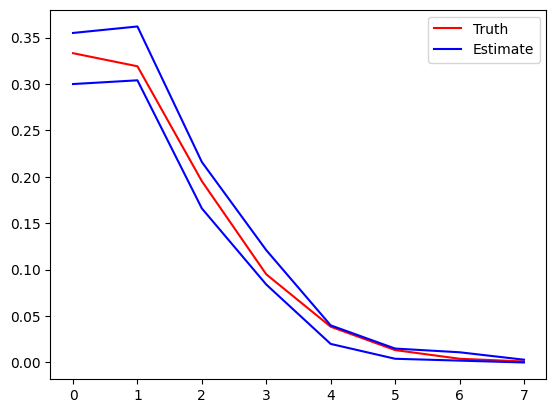

In [59]:
plt.plot(p, color="red", label="Truth")
plt.plot(p_est[0, :], color="blue", label="Estimate")
plt.plot(p_est[1, :], color="blue")
plt.legend()

## Bootstrapped p(k_c|m) / p(beta_c|m) MAY NOT agree with truth (poisson and poisson mixture bayes rule)

NOTE: assuming k_c = beta_C * k_tx for a constant base rate k_tx, so distributions p(k_c|m) and p(beta_c|m) are the same

Estimating the distribution of capture efficiency given an observed count of m via bootstrapping produces intervals on probabilities that do not always agree with the true values*.

(*True values are computed using bayes rule p(beta_c|m) = p(m|beta_c) * p(beta_c) / p(m) where p(m|beta_c) ~ Poi(beta_c * k_tx / k_deg), p(beta_c) is as chosen (e.g. 1 / B) and p(m) is Poisson mixture over beta distribution)

In [ ]:
def bootstrap_conditional(m, beta, downsampled, N=1000, n=1000):
    '''
    N: number of bootstrap samples
    n: size of each bootstrap sample
    '''

    # capture for cells with downsampled count m
    beta_m = beta[downsampled == m]

    # number of unique betas
    M = len(beta_dist) #np.unique(beta).size

    # setup estimates for p(beta|m) for each beta in each resample
    estimates = np.empty((N, M))

    # for each bootstrap sample
    for i in range(N):

        # resample
        boot = rng.choice(beta_m, size=n)

        # compute estimates over resample
        for j, b in enumerate(beta_dist):
            estimates[i, j] = int((boot == b).sum()) / n

    # take quantiles across bootstrap samples
    intervals = np.quantile(estimates, [0.025, 0.975], axis=0)

    return intervals

In [60]:
# computing p(k_c|m) = p(b|m)
m = 0
c = 0
b = beta_dist[c]

# compute p(m) exact value
p = 0
for bt in beta_dist:
    p += scipy.stats.poisson.pmf(m, bt*params['k_tx']/params['k_deg']) / len(beta_dist)

# exact value
val = scipy.stats.poisson.pmf(m, b*params['k_tx']/params['k_deg']) * (1 / len(beta_dist)) / p

# bootstrapped value
est = bootstrap_conditional(m, beta, downsampled)[:, c]

# compare
print(val, est)

0.1015363240915518 [0.071    0.107025]


### Illustration of p(k_c|m)

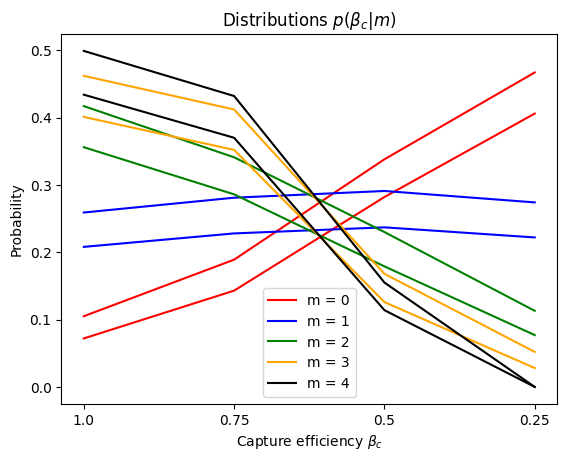

In [61]:
M = 5
colours = ["red", "blue", "green", "orange", "black"]
fig, axs = plt.subplots()
for m in range(M):
    # estimate p(k_c|m)
    p_kc_est = bootstrap_conditional(m, beta, downsampled)
    plt.plot(p_kc_est[0, :], colours[m % len(colours)], label=f"m = {m}")
    plt.plot(p_kc_est[1, :], colours[m % len(colours)])
axs.set_xticks(range(len(beta_dist)))
axs.set_xticklabels(beta_dist)
axs.set_xlabel(r"Capture efficiency $\beta_{c}$")
axs.set_ylabel("Probability")
axs.set_title(r"Distributions $p(\beta_{c} | m)$")
plt.legend()

See that for low observed counts, e.g. m = 0 in red, lower capture efficiencies (0.25) are more likely than higher values (1.0) and that as m increases, e.g. to m = 4 in black, the distribution 'tilts' so higher capture efficiencies (1.0) are more likely than lower values (0.25).

This is an intuitive result and gives confidence that the code works properly

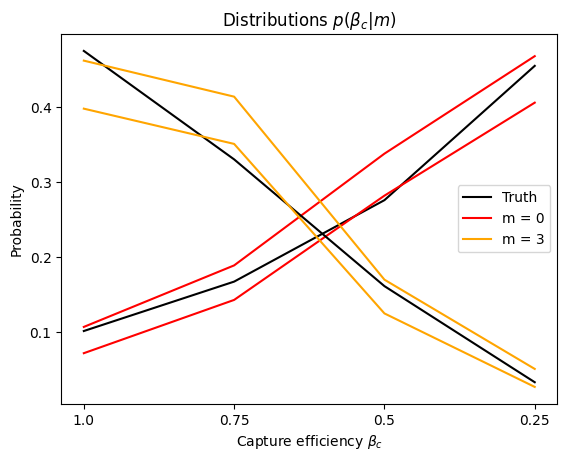

In [63]:
M = 10

# exact p(m)'s
p = np.zeros(M)
for b in beta_dist:
    p += scipy.stats.poisson.pmf([m for m in range(M)], b * params['k_tx'] / params['k_deg']) / len(beta_dist)

# exact p(k_c|m)'s
p_kc = np.zeros((len(beta_dist), M))
for j, b in enumerate(beta_dist):
    for m in range(M):
        p_kc[j, m] = scipy.stats.poisson.pmf(m, b*params['k_tx']/params['k_deg']) * (1 / len(beta_dist)) / p[m]

m_list = [0, 3]
colours = ["red", "blue", "green", "orange", "black"]
fig, axs = plt.subplots()
true_label="Truth"
for m in m_list:
    # estimate p(k_c|m)
    p_kc_est = bootstrap_conditional(m, beta, downsampled)
    plt.plot(p_kc[:, m], "black", label=true_label)
    plt.plot(p_kc_est[0, :], colours[m % len(colours)], label=f"m = {m}")
    plt.plot(p_kc_est[1, :], colours[m % len(colours)])
    true_label=None
axs.set_xticks(range(len(beta_dist)))
axs.set_xticklabels(beta_dist)
axs.set_xlabel(r"Capture efficiency $\beta_{c}$")
axs.set_ylabel("Probability")
axs.set_title(r"Distributions $p(\beta_{c} | m)$")
plt.legend()

However, we see that the confidence intervals for the probabilities of these distributions frequently do not contain the true values (shown in black for two examples)

## Exact values satisfy CME

To verify that the CME on the downsampled count scale is valid (m = observed count values):

$$ f_{m-1} p(m - 1) - f_{m} p(m) + k_{deg} (m + 1) p(m + 1) - k_{deg} m p(m) = 0 $$

$$ f_{m} = \left(\sum_{\beta_{c}} \beta_{c} p(\beta_{c} \vert m) \right) k_{tx} $$

We use the exact probability values computed using the known Poisson / mixture properties and show the CME does = 0 and so the assumption of $k_{c} = \beta_{c} k_{tx} $ is exactly true in the poisson case

In [64]:
M = 3
p = np.zeros(M)
for b in beta_dist:
    p += scipy.stats.poisson.pmf([m for m in range(M)], b * params['k_tx'] / params['k_deg']) / len(beta_dist)

f0 = 0
for b in beta_dist:
    f0 += b * params['k_tx'] * scipy.stats.poisson.pmf(0, b*params['k_tx']/params['k_deg']) * (1 / len(beta_dist)) / p[0]

f1 = 0
for b in beta_dist:
    f1 += b * params['k_tx'] * scipy.stats.poisson.pmf(1, b*params['k_tx']/params['k_deg']) * (1 / len(beta_dist)) / p[1]

In [65]:
m = 1
f0*p[m - 1] - f1*p[m] + params['k_deg']*(m + 1)*p[m + 1] - params['k_deg']*m*p[m]

np.float64(5.551115123125783e-17)

In [66]:
# NOTE: fm = (m + 1) p(m + 1) / p(m)
d1 = f1 - (1 + 1) * p[2] / p[1]
d2 = f0 - (0 + 1) * p[1] / p[0]

d1, d2

(np.float64(0.0), np.float64(1.1102230246251565e-16))

Note also that the property that

$$ f_{m} = (m + 1) \frac{p(m + 1)}{p(m)}$$

## Bootstrapped values satisfy CME

Now test if the estimated probabilities and $f_{m}$ satisfy the CME by substituting the confidence intervals and checking that the overall confidence interval for the equation contains 0.

(NOTE: need to flip intervals when subtracting as the new lower bound = negative of the old upper bound)

In [67]:
# estimate p(m)'s
p_est = bootstrap_p(downsampled)

# estimate p(k_c|m)'s
p_kc_0 = bootstrap_conditional(0, beta, downsampled)
p_kc_1 = bootstrap_conditional(1, beta, downsampled)

# estimate fm's
f0_est = np.zeros(2)
f1_est = np.zeros(2)
for j, b in enumerate(beta_dist):
    f0_est += b * params['k_tx'] * p_kc_0[:, j]
    f1_est += b * params['k_tx'] * p_kc_1[:, j]

In [68]:
m = 1

# lower bound
lb = f0_est[0]*p_est[0, m - 1] - f1_est[1]*p_est[1, m] + params['k_deg']*(m + 1)*p_est[0, m + 1] - params['k_deg']*m*p_est[1, m]

# upper bound
ub = f0_est[1]*p_est[1, m - 1] - f1_est[0]*p_est[0, m] + params['k_deg']*(m + 1)*p_est[1, m + 1] - params['k_deg']*m*p_est[0, m]

lb, ub

(np.float64(-0.2800000481249999), np.float64(0.16342247499999996))

See that the confidence interval does contain 0, despite issues with the $p(\beta_{c}\vert m)$ intervals not doing so.